In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install phik shap catboost boostaroota >> None

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
from phik.report import plot_correlation_matrix
from phik import report
import os
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import json
import shap
import sys
import argparse
from catboost import  CatBoostRegressor, Pool
from sklearn.model_selection import KFold,train_test_split
from boostaroota import BoostARoota
from sklearn.preprocessing import LabelEncoder
import phik
from phik.report import plot_correlation_matrix
from phik import report
# import optuna
# from optuna.integration import CatBoostPruningCallback
import statistics
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
plt.rcParams["figure.figsize"] = (12, 12)



Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Пути к файлам

In [4]:
global path_to_test,path_to_train,path_to_regions

path_to_test = '/content/drive/MyDrive/solovey/10.09.23'
path_to_train = '/content/drive/MyDrive/solovey/10.09.23'
path_to_regions = '/content/drive/MyDrive/solovey/10.09.23/ind_groups.csv'

# Метрики

In [5]:
rmse =lambda y_test,y_pred: mean_squared_error(y_test, y_pred)** 0.5
mape = lambda y_test,y_pred: mean_absolute_percentage_error(y_test,y_pred)

In [6]:
# parser = argparse.ArgumentParser(description = 'train')
# parser.add_argument('--n_bundle')

# args = parser.parse_args()
# n_bundles = [int(x) for x in (args.n_bundle).split(',')]

# Метрики Заказчика

In [7]:
# подсчет специальной метрики

def new_new_metric(true_values, predicted_value,metric_X,metric_Y, df_):
    true_values = np.array(true_values)
    n = len(true_values)

    deviation = abs(true_values - predicted_value) / true_values * 100

    for percent in [1, 3, 5, 10, 15, 20, 25]:
        df_[f'не более {percent}%'] = deviation <= percent
        count_val = len(deviation[deviation <= percent])
        metric_X[f'не более {percent}%'] += count_val
    for percent in [200, 150, 100, 75, 50, 25]:
        df_[f'более {percent}%'] = deviation > percent
        count_val = len(deviation[deviation > percent])
        metric_Y[f'более {percent}%'] += count_val
    return metric_X, metric_Y, df_



def validate_XY(true_values,predicted_values):
    metric_X, metric_Y = {}, {}
    res_df = pd.DataFrame()


    for percent in [1, 3, 5, 10, 15, 20, 25]:
        count_val = 0
        metric_X[f'не более {percent}%'] = count_val
    for percent in [200, 150, 100, 75, 50, 25]:
        count_val = 0
        metric_Y[f'более {percent}%'] = count_val

    metric_X, metric_Y, res_df = new_new_metric(true_values,predicted_values,metric_X,metric_Y,res_df)

    return metric_X, metric_Y, res_df

In [8]:
# функция, определяющая группу отрасли специализации региона
def get_group(region):

    groups = [] # группы, к которым принадлежит регион
    for industry in industry_dict.items():
        if region in industry[1]:
            groups.append(industry[0])
    return groups
#Label encoding  для столбца industry group
def preprocess_columns(df):
    df['industry_group'] = df['industry_group'].apply(lambda x: ', '.join(x))
    le = preprocessing.LabelEncoder()
    df['industry_group'] = le.fit_transform(df['industry_group'])
    try:
        if len(le) == 4:
            df['industry_group'] = df['industry_group'].replace(0, 1)
            df['industry_group'] = df['industry_group'].replace(1, 0)
            df['industry_group'] = df['industry_group'].replace(2, 1)
            df['industry_group'] = df['industry_group'].replace(3, 2)
    except:
        ...
    # Обратное преобразование, если необходимо
    # df['industry_group'] = le.inverse_transform(df['industry_group'])
    return df


def set_industry_group(df_):

    # Определяем регионы для студентов
    student_regions = ['Город федерального значения Москва', 'Город федерального значения Санкт-Петербург', 'Республика Татарстан', 'Ростовская область', 'Свердловская область', 'Краснодарский край', 'Республика Башкортостан', 'Новосибирская область', 'Самарская область', 'Челябинская область', 'Нижегородская область']

    # Определяем сельскохозяйственные регионы
    selhoz_regions = ['Краснодарский край', 'Ростовская область', 'Белгородская область', 'Республика Татарстан', 'Воронежская область',
                      'Ставропольский край', 'Республика Башкортостан', 'Алтайский край', 'Волгоградская область', 'Тамбовская область',
                      'Челябинская область', 'Саратовская область', 'Московская область', 'Курская область', 'Оренбургская область']
    selhoz_regions = list(set(selhoz_regions) - set(student_regions))

    prom_regions = list(set(df_['region_name']) - set(student_regions) - set(selhoz_regions))

    global industry_dict

    industry_dict = {'промышленность':prom_regions,
                     'сельское хозяйство':selhoz_regions,
                     'образование':student_regions}


    df_['industry_group'] = df_['region_name'].apply(get_group)
    df_['experience_id'] = df_['experience_id'].apply(lambda x: x if x != 3 else 2)

    return df_


In [9]:
def get_test(df):
    train = df
    test = pd.DataFrame()
    for is_vahta in [0,1]:
        for experience_id in [[0], [1], [2,3]]:
            for industry_group in [0, 1, 2]:
                curr_df = df[(df.is_vahta == is_vahta) & (df.experience_id.isin(experience_id)) \
                             & (df.industry_group == industry_group)]
                if curr_df.shape[0] < 10:
                    curr_test = pd.DataFrame()

                else:
                    train_size_middle = int(curr_df.shape[0] * 0.75)
                    test_size_middle = curr_df.shape[0] - train_size_middle

                    train_size_side = int(curr_df.shape[0] * 0.85)
                    test_size_side = curr_df.shape[0] - train_size_side # сумма коэф. на которые умножаются размеры должна быть равна 1.8

                    lower_bound = statistics.mode(curr_df['new_salary']) - curr_df['new_salary'].std()
                    upper_bound = statistics.mode(curr_df['new_salary']) + curr_df['new_salary'].std()

                    middle_group = curr_df[(curr_df.new_salary >= lower_bound) & (curr_df.new_salary <= upper_bound)]
                    side_group = curr_df[~((curr_df.new_salary >= lower_bound) & (curr_df.new_salary <= upper_bound))]



                    middle_group, side_group = shuffle(middle_group), shuffle(side_group)

                    middle_group_test = middle_group.iloc[0:test_size_middle]
                    side_group_test = side_group.iloc[0:test_size_side]

                    curr_test = pd.concat([middle_group_test, side_group_test])



                if len(test) and len(curr_test):
                    test = pd.concat([curr_test, test])
                elif len(curr_test):
                    test = curr_test

    return test

In [28]:
def fit_catboost(train, val,param, cat_features):
    try:
        param.pop('callbacks')
    except:
        ...


    X_train, y_train = train
    X_val, y_val = val


    clf = CatBoostRegressor(
        **param,
        thread_count=-1
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds = 50,
        cat_features = cat_features
    )


    return clf

In [11]:
def make_dir(path):
    try:
        os.mkdir(path)
    except:
        ...

In [12]:
def write_log(path,log):
    with open(path, 'a+') as f:
        f.write_line(log + "\n")



In [15]:
region = pd.read_csv(path_to_regions)

In [16]:
custom_metric_less = ['не более 1%', 'не более 3%', 'не более 5%', 'не более 10%', 'не более 15%', 'не более 20%', 'не более 25%']
custom_metric_more = ['более 200%', 'более 150%', 'более 100%', 'более 75%', 'более 50%', 'более 25%']

# 1-25 и 26-50 профессии соотв

In [17]:
first25 = [16, 27, 31, 33, 49, 52, 54, 58, 61, 69, 74, 91, 116, 119, 128, 134, 283, 336, 663, 706, 767, 783, 833, 836, 919]
second25 = [23, 43, 84, 85, 87, 124, 357, 561, 693, 712, 742, 765, 811, 812, 852, 853, 856, 873, 876, 888, 898, 917, 921, 954, 992]

In [ ]:
path_to_res_csv = '/home/admin/skill_value/results/results2708/comparison_analysis.csv'
path_to_log = '/home/admin/skill_value/results/results2708/log.txt'

In [18]:
n_bundles = first25 + second25

In [19]:
def get_phik(df,n_bundle,num_features_to_select,is_elim):
    phik_overview = df.phik_matrix().round(2)

    plot_correlation_matrix(phik_overview.values,
                            x_labels=phik_overview.columns,
                            y_labels=phik_overview.index,
                            vmin=0, vmax=1, color_map="Greens",
                            title=r"correlation $\phi_K$",
                            fontsize_factor=0.8, figsize=(16, 9))
    plt.tight_layout()
    plt.savefig(f"/home/admin/skill_value/results/results0309/phik/{n_bundle}/{num_features_to_select}/{is_elim}_{n_bundle}_corr.jpeg")
    plt.close()
    phik_overview.to_csv(f"/home/admin/skill_value/results/results0309/phik/{n_bundle}/{num_features_to_select}/{is_elim}_{n_bundle}_corr.csv",index = False)

    significance_overview = df.significance_matrix().fillna(0).round(1)

    plot_correlation_matrix(significance_overview.values,
                            x_labels=significance_overview.columns,
                            y_labels=significance_overview.index,
                            vmin=0, vmax=1, color_map="Greens",
                            title="Significance of the coefficients",
                            usetex=False, fontsize_factor=0.8, figsize=(16, 9))
    plt.tight_layout()
    plt.savefig(f"/home/admin/skill_value/results/results0309/phik/{n_bundle}/{num_features_to_select}/{is_elim}_{n_bundle}_sign.jpeg")
    significance_overview.to_csv(f"/home/admin/skill_value/results/results0309/phik/{n_bundle}/{num_features_to_select}/{is_elim}_{n_bundle}_sign.csv",index = False)
    plt.close()


In [30]:
for n_bundle in [954]:

        train = pd.read_csv(f"{path_to_train}/based_b_{n_bundle}.csv")
        #Фильтруем выбросы сверху + делаем не ниже чуть меньше МРОТа
        train = train[(train.new_salary < np.quantile(train.new_salary,0.9972)) &
                (11500 < train.new_salary)]
        cat_features = ['region_name']


        if int(n_bundle) in first25:
                test = pd.read_csv(f"{path_to_test}/based_b_{n_bundle}.csv")
                is_first_25 = 1
        #         test = pd.read_csv(f"{path_to_test}/Bundles_{n_bundle}.csv")
                test = test[test.new_salary > 11500]
                # test['new_salary'] = test['new_salary_quantile']
                # test.drop(['salary_from_rub','new_salary_quantile','new_salary_z_score'],axis = 1,inplace = True)
                # test = set_industry_group(test)

        else:
                is_first_25 = 0
                test = get_test(train)



        model_before_test = CatBoostRegressor(cat_features=cat_features)
        model_before_test.load_model(f'/home/admin/skill_value/results/results2708/models/{n_bundle}.cbm')

        a = list(test)
        b = list(train)
        columns = np.unique([x for x in a + b if x in a and x in b])
        train = train[columns]

        y = train["new_salary"]
        X = train.drop('new_salary',axis =1)

        X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.25, random_state=7575)

        model_before = fit_catboost((X_train,y_train), (X_test,y_test), model_before_test.get_params(), cat_features)
        make_dir(f'/home/admin/skill_value/results/results0309/models/{n_bundle}')
        model_before.save_model(f'/home/admin/skill_value/results/results0309/models/{n_bundle}/{n_bundle}.cbm')

        predict_before = model_before.predict(test[model_before.feature_names_])



        mape_before = mape(test.new_salary,predict_before)
        rmse_before = rmse(test.new_salary,predict_before)

        explainer = shap.TreeExplainer(model_before)
        val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
        shap_values = explainer.shap_values(val_dataset)
        fig=plt.gcf()
        shap.summary_plot(shap_values, X_test)
        make_dir(f"/home/admin/skill_value/results/results0309/shap/{n_bundle}")
        fig.savefig(f"/home/admin/skill_value/results/results0309/shap/{n_bundle}/{n_bundle}.jpeg", bbox_inches='tight')


        for coef_num in [5,15]:
                num_features_to_select = int((X_train.shape[1]-1) -coef_num)
                summary = model_before.select_features(X_train, y_train,
                eval_set=(X_test, y_test),
                features_for_select=f'0-{X_train.shape[1]-1}',
                num_features_to_select=num_features_to_select,
                steps=2,
                train_final_model=False,
                logging_level='Silent')


                make_dir('/home/admin/skill_value/results/results0309/summaries')
                make_dir(f'/home/admin/skill_value/results/results0309/summaries/{n_bundle}')
                with open(f'/home/admin/skill_value/results/results0309/summaries/{n_bundle}/{n_bundle}_{num_features_to_select}.json', 'w') as f:
                        json.dump(summary, f,ensure_ascii=False,indent = 2)

                y = train["new_salary"]
                X = train[summary['selected_features_names']]

                X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.25, random_state=7575)

                new_model = fit_catboost((X_train,y_train), (X_test,y_test), model_before.get_params())


                new_model.save_model(f'/home/admin/skill_value/results/results0309/models/{n_bundle}/{n_bundle}_after_filter_{int(num_features_to_select)}.cbm')


                predict_after = new_model.predict(test[new_model.feature_names_])


                mape_after = mape(test.new_salary,predict_after)
                rmse_after = rmse(test.new_salary,predict_after)



                index = test.index
                experience_id = test.experience_id
                industry_group = test.industry_group
                year = test.year
                is_vahta = test.is_vahta
                region_name = test.region_name


                res_csv = pd.read_csv(path_to_res_csv)




                sc = pd.DataFrame({}, columns = list(res_csv))

                sc['n_bundle'] = n_bundle
                sc['index'] = index
                sc['year'] = year
                sc['is_vahta'] = is_vahta
                sc['experience_id'] = experience_id
                sc['industry_group'] = industry_group
                sc['region_name'] = region_name
                sc['mape_before'] = np.round(mape_before,3)
                sc['mape_after'] = np.round(mape_after,3)
                sc['rmse_before'] = round(rmse_before)
                sc['rmse_after'] = round(rmse_after)
                sc['is_first_25'] = is_first_25
                sc['num_features_to_select'] = num_features_to_select
                sc['predict_before'] = predict_before
                sc['predict_after'] = predict_after
                sc['actual_values'] = test.new_salary
                sc['n_bundle'] = n_bundle

                combined_df = pd.concat([res_csv, sc], ignore_index=True)
                make_dir("/home/admin/skill_value/results/results0309/res_csv")
                make_dir(f"/home/admin/skill_value/results/results0309/res_csv/{n_bundle}")
                combined_df.to_csv(f"/home/admin/skill_value/results/results0309/res_csv/{n_bundle}/{n_bundle}_{int(num_features_to_select)}.csv",index = False)


FileNotFoundError: ignored

# task 4

метрики:  0.15368087367782562 14716.049450396345


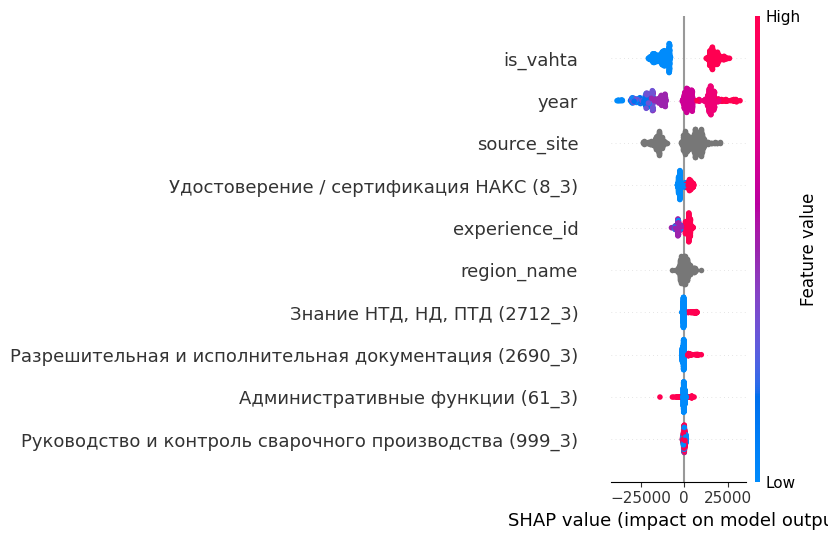

In [35]:
n_bundles = [898]
for n_bundle in n_bundles:

        train = pd.read_csv(f"{path_to_train}/based_b_{n_bundle}.csv")
        #Фильтруем выбросы сверху + делаем не ниже чуть меньше МРОТа
        train = train[(train.new_salary < np.quantile(train.new_salary,0.9972)) &
                (11500 < train.new_salary)]
        cat_features = ['region_name','source_site']


        if int(n_bundle) in first25:
                test = pd.read_csv(f"{path_to_test}/based_b_{n_bundle}.csv")
                is_first_25 = 1
        #         test = pd.read_csv(f"{path_to_test}/Bundles_{n_bundle}.csv")

                test = test[test.new_salary > 11500]
                test_index = test.id
                # test['new_salary'] = test['new_salary_quantile']
                # test.drop(['salary_from_rub','new_salary_quantile','new_salary_z_score'],axis = 1,inplace = True)
                # test = set_industry_group(test)

        else:
                is_first_25 = 0
                test = get_test(train)
                test_index = test.index


        model_before_test = CatBoostRegressor(cat_features=cat_features)
        model_before_test.load_model(f'/content/drive/MyDrive/solovey/10.09.23/898.cbm')
        a = list(test)
        b = list(train)
        columns = np.unique([x for x in a + b if x in a and x in b])
        train = train[columns]

        y = train["new_salary"]
        X = train.drop(['new_salary','salary_from_rub','id'],axis =1,errors = 'ignore')

        X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.25, random_state=7575)

        model_before = fit_catboost((X_train,y_train), (X_test,y_test), model_before_test.get_params(), cat_features=cat_features)
        model_before.save_model(f'/content/drive/MyDrive/solovey/10.09.23/{n_bundle}/{n_bundle}.cbm')

        predict_before = model_before.predict(test[model_before.feature_names_])



        mape_before = mape(test.new_salary,predict_before)
        rmse_before = rmse(test.new_salary,predict_before)
        print('метрики: ', mape_before, rmse_before)


        explainer = shap.TreeExplainer(model_before)
        val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
        shap_values = explainer.shap_values(val_dataset)
        fig=plt.gcf()
        shap.summary_plot(shap_values, X_test, max_display = 10)
        # fig.savefig(f"/home/admin/skill_value/results/results0309/shap/{n_bundle}/{n_bundle}_{num_features_to_select}.jpeg", bbox_inches='tight')


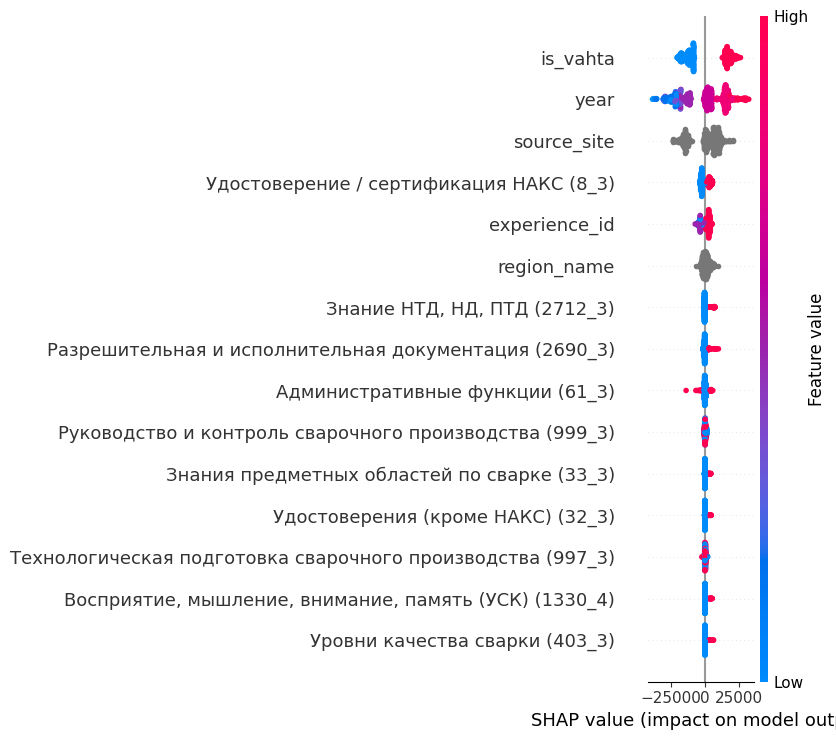

In [37]:
explainer = shap.TreeExplainer(model_before)
val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
shap_values = explainer.shap_values(val_dataset)
fig=plt.gcf()
shap.summary_plot(shap_values, X_test, max_display = 15)

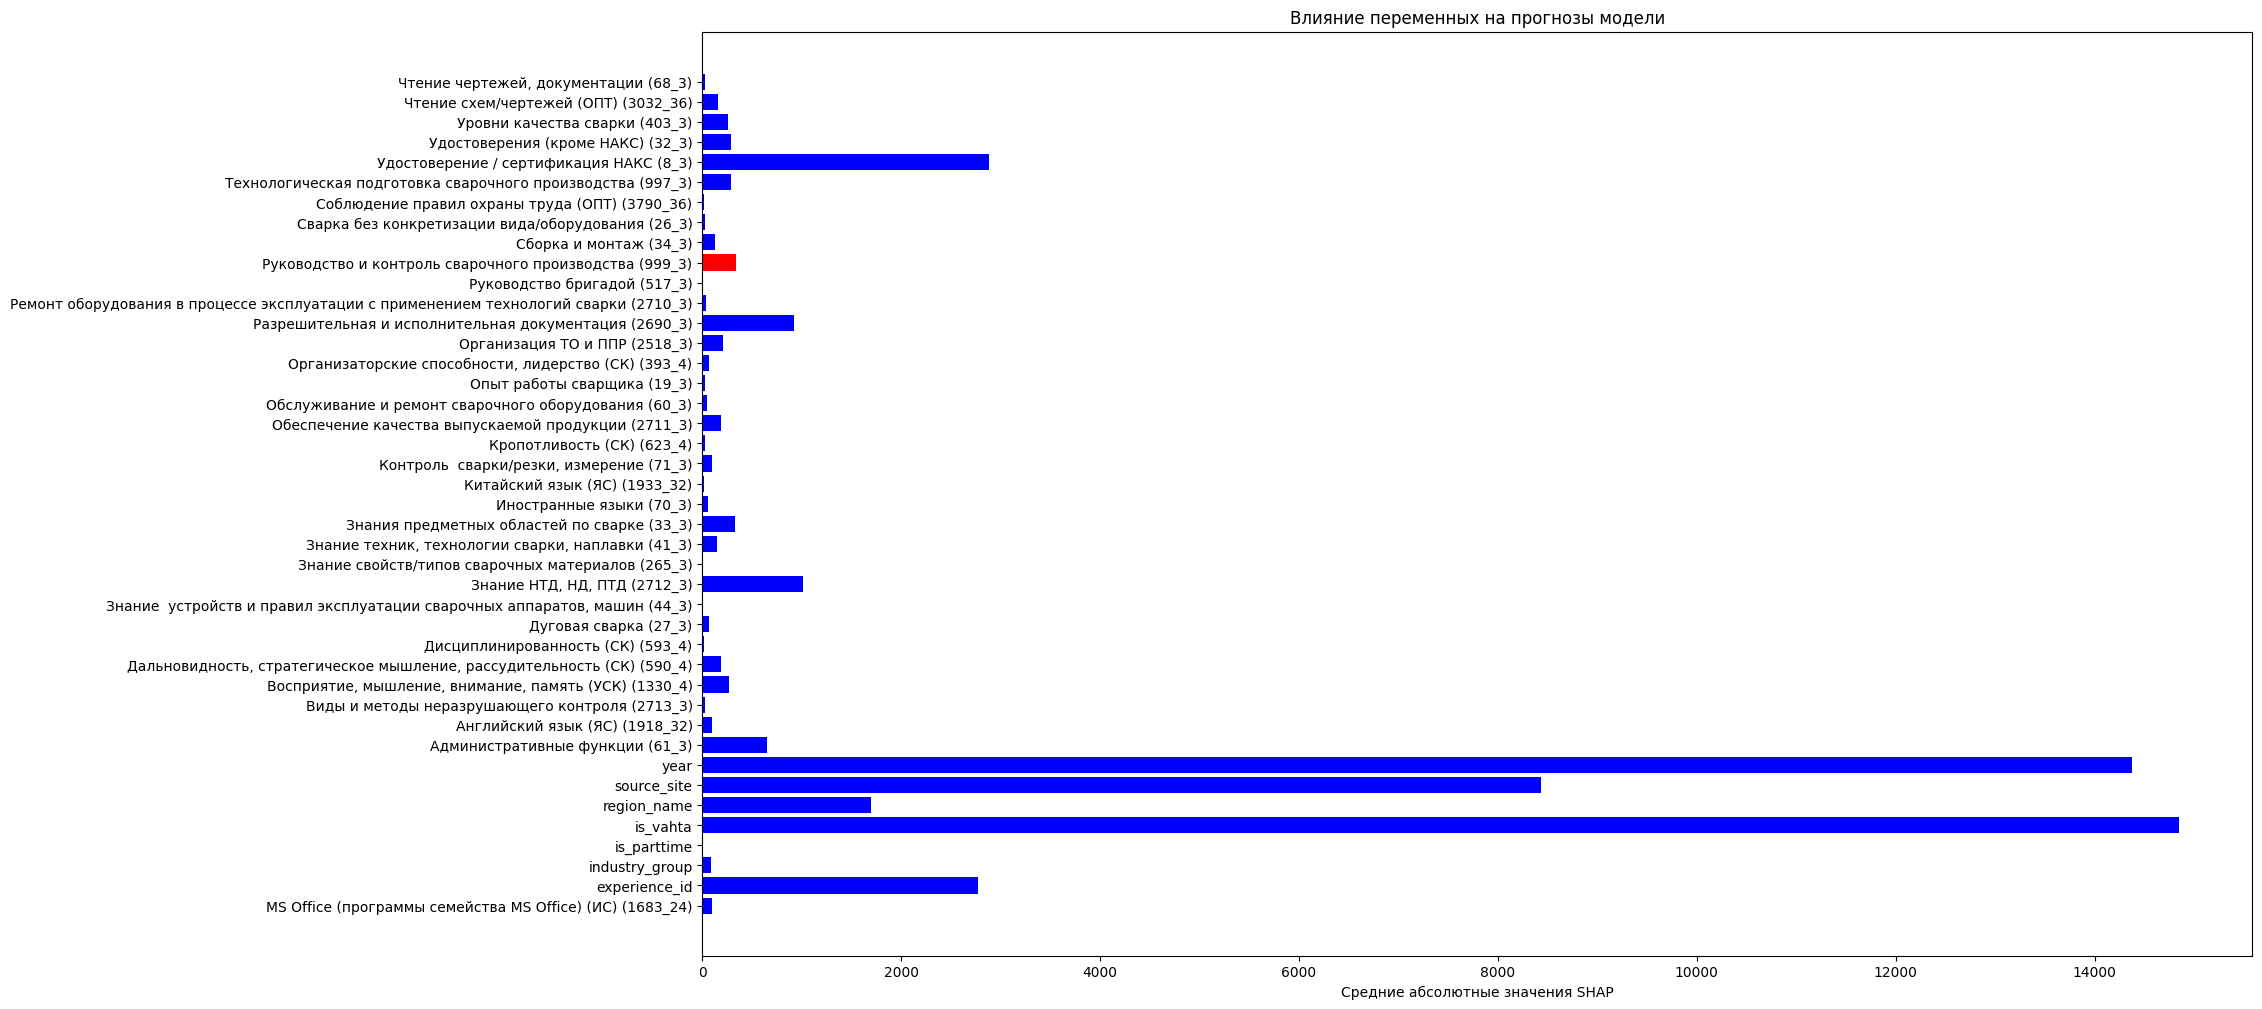

In [57]:

# Инициализация TreeExplainer для модели model_before
explainer = shap.TreeExplainer(model_before)

# Создание Pool объекта для данных X_test и y_test
val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

# Вычисление SHAP-значений
shap_values = explainer.shap_values(val_dataset)

# Вычисление средних абсолютных значений SHAP
mean_shap_values = abs(shap_values).mean(axis=0)

# Получение имён признаков
feature_names = X_test.columns

colors = ['red' if feature_name == 'Руководство и контроль сварочного производства (999_3)' else 'blue' for feature_name in feature_names]

# Создание гистограммы
plt.figure(figsize=(20, 12))
plt.barh(feature_names, mean_shap_values, color=colors)
plt.xlabel('Средние абсолютные значения SHAP')
plt.title('Влияние переменных на прогнозы модели')
plt.show()


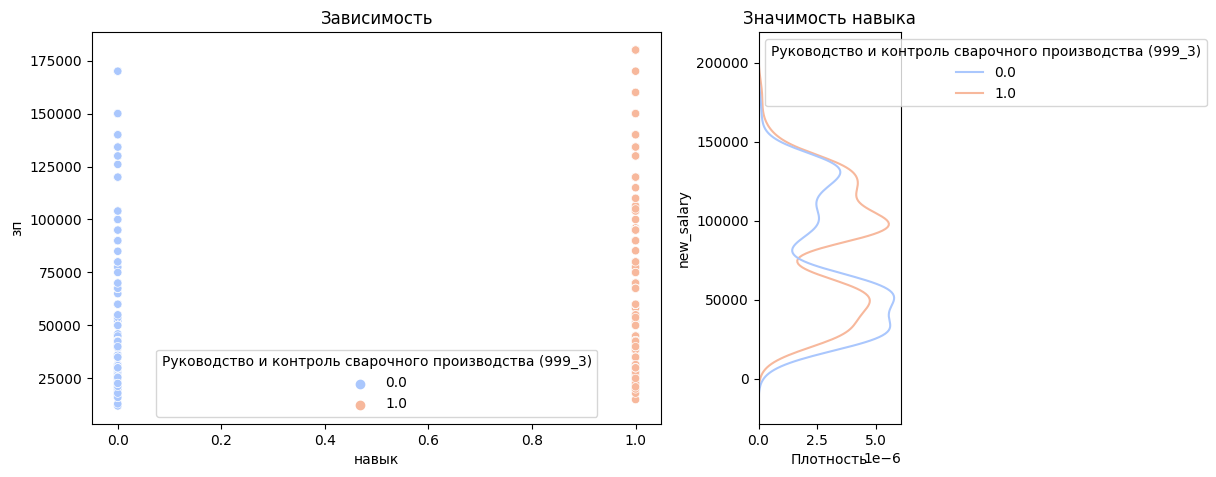

In [54]:
# для трейна

# Создайте график
plt.figure(figsize=(12, 6))

# Создайте разделенные графики (для основной зависимости и дополнительной особенности)
gs = plt.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[4, 1])

# Основной график - зависимость процента рабочего класса от концентрации NOX
ax_main = plt.subplot(gs[0])
sns.scatterplot(x=X_train['Руководство и контроль сварочного производства (999_3)'], y=y_train, hue=X_train['Руководство и контроль сварочного производства (999_3)'], palette='coolwarm', ax=ax_main)
ax_main.set_xlabel('навык')
ax_main.set_ylabel('зп')
ax_main.set_title('Dependence salary and skill (999_3)')

# График с боковой шкалой - показывает значимость особенности feature_of_interest
ax_side = plt.subplot(gs[1])
sns.kdeplot(data=y_train, hue=X_train['Руководство и контроль сварочного производства (999_3)'], palette='coolwarm', ax=ax_side, vertical=True)
ax_side.set_xlabel('Плотность')
ax_side.set_title(f'Значимость навыка')

plt.tight_layout()
plt.show()


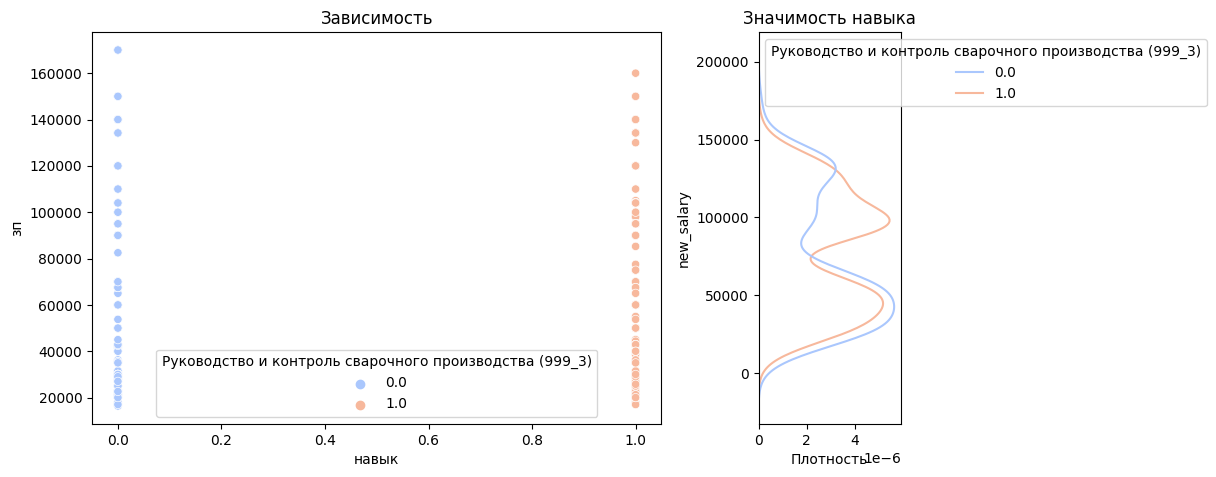

In [59]:
# для теста

# Создайте график
plt.figure(figsize=(12, 6))

# Создайте разделенные графики (для основной зависимости и дополнительной особенности)
gs = plt.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[4, 1])

# Основной график - зависимость процента рабочего класса от концентрации NOX
ax_main = plt.subplot(gs[0])
sns.scatterplot(x=X_test['Руководство и контроль сварочного производства (999_3)'], y=y_test, hue=X_test['Руководство и контроль сварочного производства (999_3)'], palette='coolwarm', ax=ax_main)
ax_main.set_xlabel('навык')
ax_main.set_ylabel('зп')
ax_main.set_title('Зависимость')

# График с боковой шкалой - показывает значимость особенности feature_of_interest
ax_side = plt.subplot(gs[1])
sns.kdeplot(data=y_test, hue=X_test['Руководство и контроль сварочного производства (999_3)'], palette='coolwarm', ax=ax_side, vertical=True)
ax_side.set_xlabel('Плотность')
ax_side.set_title(f'Значимость навыка')

plt.tight_layout()
plt.show()


# продолжение бейза


In [32]:
n_bundles = [898]
for n_bundle in n_bundles:

        train = pd.read_csv(f"{path_to_train}/based_b_{n_bundle}.csv")
        #Фильтруем выбросы сверху + делаем не ниже чуть меньше МРОТа
        train = train[(train.new_salary < np.quantile(train.new_salary,0.9972)) &
                (11500 < train.new_salary)]
        cat_features = ['region_name','source_site']


        if int(n_bundle) in first25:
                test = pd.read_csv(f"{path_to_test}/based_b_{n_bundle}.csv")
                is_first_25 = 1
        #         test = pd.read_csv(f"{path_to_test}/Bundles_{n_bundle}.csv")

                test = test[test.new_salary > 11500]
                test_index = test.id
                # test['new_salary'] = test['new_salary_quantile']
                # test.drop(['salary_from_rub','new_salary_quantile','new_salary_z_score'],axis = 1,inplace = True)
                # test = set_industry_group(test)

        else:
                is_first_25 = 0
                test = get_test(train)
                test_index = test.index


        model_before_test = CatBoostRegressor(cat_features=cat_features)
        model_before_test.load_model(f'/content/drive/MyDrive/solovey/10.09.23/898.cbm')
        a = list(test)
        b = list(train)
        columns = np.unique([x for x in a + b if x in a and x in b])
        train = train[columns]

        y = train["new_salary"]
        X = train.drop(['new_salary','salary_from_rub','id'],axis =1,errors = 'ignore')

        X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.25, random_state=7575)

        model_before = fit_catboost((X_train,y_train), (X_test,y_test), model_before_test.get_params(), cat_features=cat_features)
        # make_dir(f'/home/admin/skill_value/results/results0309/models')
        # make_dir(f'/home/admin/skill_value/results/results0309/models/{n_bundle}')
        model_before.save_model(f'/content/drive/MyDrive/solovey/10.09.23/{n_bundle}/{n_bundle}.cbm')
        print('четка')

        predict_before = model_before.predict(test[model_before.feature_names_])



        mape_before = mape(test.new_salary,predict_before)
        rmse_before = rmse(test.new_salary,predict_before)

        # explainer = shap.TreeExplainer(model_before)
        # val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
        # shap_values = explainer.shap_values(val_dataset)
        # fig=plt.gcf()
        # shap.summary_plot(shap_values, X_test, max_display = 25)
        # make_dir(f"/home/admin/skill_value/results/results0309/shap/{n_bundle}")
        # fig.savefig(f"/home/admin/skill_value/results/results0309/shap/{n_bundle}/{n_bundle}.jpeg", bbox_inches='tight')


        for coef_num in [10,20]:
                num_features_to_select = int((X_train.shape[1]-1) -coef_num)
                summary = model_before.select_features(X_train, y_train,
                eval_set=(X_test, y_test),
                features_for_select=f'0-{X_train.shape[1]-1}',
                num_features_to_select=num_features_to_select,
                steps=2,
                train_final_model=False,
                logging_level='Silent')


                make_dir('/home/admin/skill_value/results/results0309/summaries')
                with open(f'/home/admin/skill_value/results/results0309/summaries/{n_bundle}_{num_features_to_select}.json', 'w') as f:
                        json.dump(summary, f,ensure_ascii=False,indent = 2)

                y = train["new_salary"]
                X = train[summary['selected_features_names']]

                X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.25, random_state=7575)

                new_model = fit_catboost((X_train,y_train), (X_test,y_test), model_before.get_params())

                new_model.save_model(f'/content/drive/MyDrive/solovey/10.09.23/{n_bundle}/{n_bundle}_after_filter_{int(num_features_to_select)}.cbm')
                # new_model.save_model(f'/home/admin/skill_value/results/results0309/models/{n_bundle}/{n_bundle}_after_filter_{int(num_features_to_select)}.cbm')

                explainer = shap.TreeExplainer(new_model)
                val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)
                shap_values = explainer.shap_values(val_dataset)
                fig=plt.gcf()
                shap.summary_plot(shap_values, X_test, max_display = 25)
                make_dir(f"/home/admin/skill_value/results/results0309/shap")
                make_dir(f"/home/admin/skill_value/results/results0309/shap/{n_bundle}")
                fig.savefig(f"/home/admin/skill_value/results/results0309/shap/{n_bundle}/{n_bundle}_{num_features_to_select}.jpeg", bbox_inches='tight')

                predict_after = new_model.predict(test[new_model.feature_names_])


                mape_after = mape(test.new_salary,predict_after)
                rmse_after = rmse(test.new_salary,predict_after)



                # experience_id = test.experience_id
                # industry_group = test.industry_group
                # year = test.year
                # is_vahta = test.is_vahta
                # region_name = test.region_name
                # is_parttime = test.is_parttime
                # source = test.source_site


                # res_csv = pd.read_csv(path_to_res_csv)

                # sc = pd.DataFrame({}, columns = list(res_csv))

                # sc['n_bundle'] = n_bundle
                # sc['index'] = test_index
                # sc['year'] = year
                # sc['is_vahta'] = is_vahta
                # sc['experience_id'] = experience_id
                # sc['industry_group'] = industry_group
                # sc['region_name'] = region_name
                # sc['mape_before'] = np.round(mape_before,3)
                # sc['mape_after'] = np.round(mape_after,3)
                # sc['rmse_before'] = round(rmse_before)
                # sc['rmse_after'] = round(rmse_after)
                # sc['is_first_25'] = is_first_25
                # sc['num_features_to_select'] = num_features_to_select
                # sc['predict_before'] = predict_before
                # sc['predict_after'] = predict_after
                # sc['actual_values'] = test.new_salary
                # sc['n_bundle'] = n_bundle

                # combined_df = pd.concat([res_csv, sc], ignore_index=True)
                # make_dir("/home/admin/skill_value/results/results0309/res_csv")
                # make_dir(f"/home/admin/skill_value/results/results0309/res_csv/{n_bundle}")
                # combined_df.to_csv(f"/home/admin/skill_value/results/results0309/res_csv/{n_bundle}/{n_bundle}_{int(num_features_to_select)}.csv",index = False)







четка


CatBoostError: ignored

In [ ]:
for k,i in enumerate(['1']):
    print(k,i)

0 1


: 

In [ ]:
for n_bundle in n_bundles:
        train = pd.read_csv(f"{path_to_train}/based_b_{n_bundle}.csv")
        #Фильтруем выбросы сверху + делаем не ниже чуть меньше МРОТа
        train = train[(train.new_salary < np.quantile(train.new_salary,0.9972)) &
                (11500 < train.new_salary)]
        cat_features = ['region_name']
        cb_before = CatBoostRegressor()
        cb_before.load_model(f"/home/admin/skill_value/results/results0309/models/{n_bundle}/{n_bundle}.cbm")



        results = pd.DataFrame({}, columns = ['n_bundle','features_count','mape','rmse']+custom_metric_less + custom_metric_more)
        cc = 0
        for submodel in os.listdir(f"/home/admin/skill_value/results/results0309/res_csv/{n_bundle}"):
                submodel = submodel.replace('.csv','')
                if int(n_bundle) in first25:
                        test = pd.read_csv(f"{path_to_test}/based_b_{n_bundle}.csv")
                        is_first_25 = 1
                #         test = pd.read_csv(f"{path_to_test}/Bundles_{n_bundle}.csv")
                        test = test[test.new_salary > 11500]
                        # test['new_salary'] = test['new_salary_quantile']
                        # test.drop(['salary_from_rub','new_salary_quantile','new_salary_z_score'],axis = 1,inplace = True)
                        # test = set_industry_group(test)

                else:
                        is_first_25 = 0
                        dt_index = pd.read_csv(f"/home/admin/skill_value/results/results0309/res_csv/{n_bundle}/{submodel}.csv").index
                        test = train[train.index.isin(dt_index)]


                cb_after = CatBoostRegressor()
                cb_after.load_model(f"/home/admin/skill_value/results/results0309/models/{n_bundle}/{n_bundle}_after_filter_{submodel.split('_')[1]}.cbm")


                predictions = test[['year','is_vahta','industry_group','experience_id','new_salary']]

                predict_before = cb_before.predict(test[cb_before.feature_names_])
                predict_after = cb_after.predict(test[cb_after.feature_names_])

                predictions['predict_before'] = predict_before
                predictions['predict_after'] = predict_after


                if cc: ...
                else:

                        X,Y,dj = validate_XY(np.array(test['new_salary']),predict_before)
                        results.loc[results.shape[0]] = [n_bundle,len(list(cb_before.feature_names_)),np.round(mape(np.array(test['new_salary']),predict_before),3),np.round(rmse(np.array(test['new_salary']),predict_before))] + list(np.round(np.array(list(X.values()))/int((X['не более 25%'] + Y['более 25%'])),3)) + list(np.round(np.array(list(Y.values()))/int((X['не более 25%'] + Y['более 25%'])),3))
                        cc += 1
                X,Y,dj = validate_XY(np.array(test['new_salary']),predict_after)
                results.loc[results.shape[0]] = [n_bundle,len(list(cb_after.feature_names_)),np.round(mape(np.array(test['new_salary']),predict_after),3),np.round(rmse(np.array(test['new_salary']),predict_after))] + list(np.round(np.array(list(X.values()))/int((X['не более 25%'] + Y['более 25%'])),3)) + list(np.round(np.array(list(Y.values()))/int((X['не более 25%'] + Y['более 25%'])),3))

                results.to_csv(f"/home/admin/skill_value/results/results0309/metrics/{n_bundle}.csv",index = False)
                predictions.to_csv(f"/home/admin/skill_value/results/results0309/predicts/{submodel}.csv",index = False)
                sumdict = json.load(open(f'/home/admin/skill_value/results/results0309/summaries/{n_bundle}_{num_features_to_select}.json'))

                get_phik(train[sumdict['selected_features_names'] + ['new_salary']], n_bundle, num_features_to_select,0)
                get_phik(train[sumdict['eliminated_features_names'] + ['new_salary']], n_bundle, num_features_to_select,1)

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 1 should be feature with name is_vahta (found experience_id).

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
